Notebook purpose

- Check whether there is a reliable way to identify savings transactions

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config

import entropy.helpers.aws as ha
import entropy.helpers.helpers as hh 
import entropy.helpers.data as hd
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile='3di')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dfs, df = hd.load_samples(['777', 'XX7'])
hd.inspect(df)

Time for read_data      : 1.76 seconds
Time for read_data      : 2.86 minutes
(6,791,894, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_tag
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948


## Tags

The simplest approach to identify savings is to use MDB auto tags. I have grouped all relevant auto tags into a `tag` called *savings*, which is a subgroup of the `tag_group` *transfters*.

In [17]:
tc.savings

['general savings',
 'investment - other',
 'investments or shares',
 'isa',
 'pension or investments',
 'saving (general)',
 'savings (general)',
 'savings']

There are not enough txns and users to work with.

In [89]:
savings = df[df.tag.eq('savings')]
hd.txns_and_users(savings, df)

df1 has 8,802 txns across 585 users (0.1% and 24.8% of df2).


## Savings account transfers

An alternative is to look at flows into and out of savings accounts. We could define something like 'monthly net savings' as the the sum of all inflows and outflows into a users savings accounts during a month.

In [139]:
savings = df[df.account_type.eq('savings')]
credits = savings[~savings.debit]
debits = savings[savings.debit]

There are many more transactions across many more users than for tags above.

In [140]:
hd.txns_and_users(savings, df)

df1 has 148,635 txns across 1347 users (2.2% and 57.1% of df2).


We'd expect credits and, to a lesser extent, debits to mostly be round amounts. The below shows that this is the case (apart from interest payments).

In [141]:
savings.amount.value_counts().iloc[:10]

 100.00    5644
 50.00     4529
-200.00    3707
-100.00    3707
 20.00     3491
-50.00     3326
 200.00    3318
 10.00     2932
-0.01      2902
 30.00     2171
Name: amount, dtype: int64

Plot distributions of monthly inflows, outflows, and net savings.

In [252]:
df[['user_id', 'amount']][:5].div([1, 2, 3, 4, 5], axis=0)

,user_id,amount
0,107.000000,9.200000
1,53.500000,3.470000
2,35.666667,2.006667
3,26.750000,1.622500
4,21.400000,7.600000


In [269]:
def make_data(df):
    
    def _is_round_amount(x, multiple=5):
        return not x % multiple
    
    def _get_savings_txns(df):
        """Keeps round savings-account txns."""
        mask = df.account_type.eq('savings') & df.amount.apply(_is_round_amount)
        return df[mask].copy()
    
    def _agg_to_inflows_outflows_net(df):
        df['debit'] = df.debit.replace({True: 'debit', False: 'credit'})
        month = pd.Grouper(key='date', freq='m')
        return (df.groupby(['user_id', month, 'income', 'debit'])
                .amount.sum().abs()
                .unstack()
                .assign(net=lambda df: df.credit - df.debit))
    
    def _scale_by_monthly_income(df):
        monthly_income = df.index.get_level_values('income') / 12
        scaled_df = df.div(monthly_income, axis='rows')
        return scaled_df.reset_index('income', drop=True)
    
    def _trim_cols(df, pct=5):
        return df.apply(hd.trim, pct=pct)
    
    return (_get_savings_txns(df)
            .pipe(_agg_to_inflows_outflows_net)
            .pipe(_scale_by_monthly_income)
            .pipe(_trim_cols)
           )


def make_figure(df):
    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle('Monthly savings account transactions as fraction of monthly income')
    for i, col in enumerate(df.columns):
        sns.histplot(x=df[col], ax=ax[i])

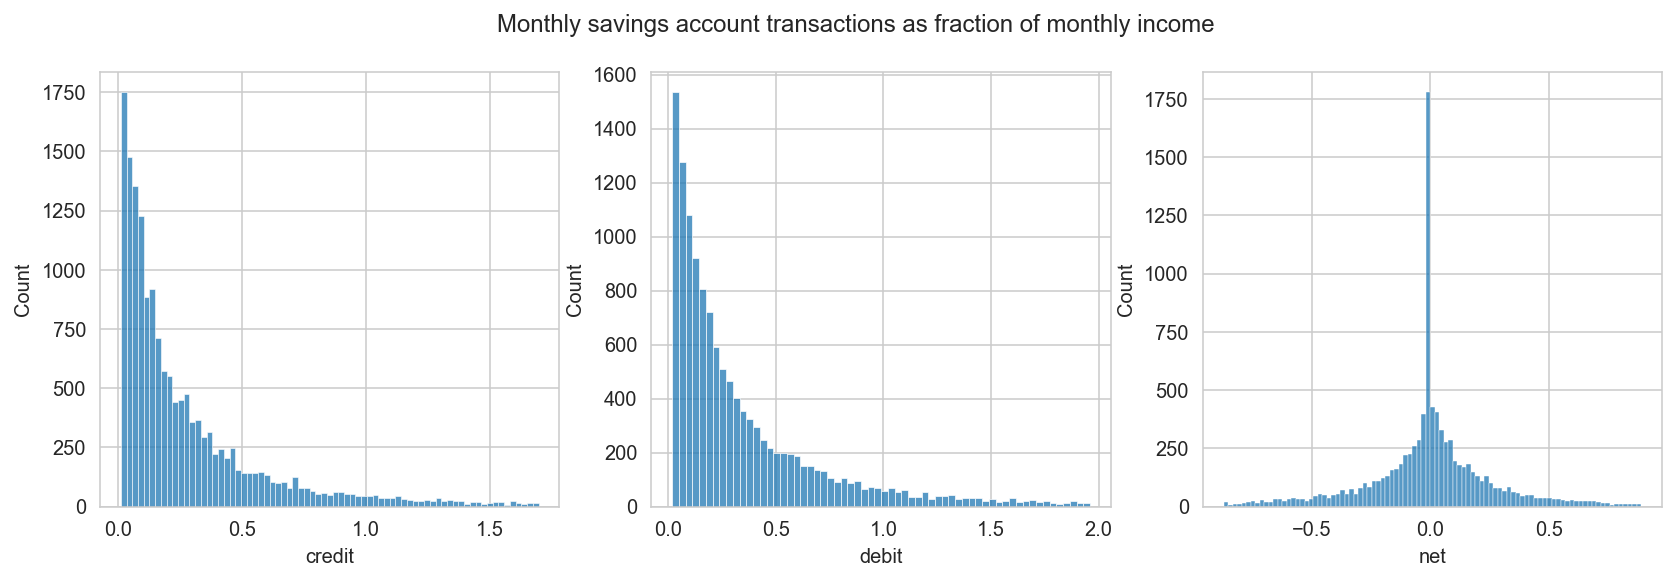

In [278]:
monthly_savings = make_data(df)  
make_figure(monthly_savings)